##Generative Adversarial Network (GAN) for MNIST


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd.variable import Variable


In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.model = nn.Sequential(
            nn.Linear(self.z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)


In [ ]:
# Hyperparameters
bs = 100  # Batch size
z_dim = 100  # Latent vector size

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset=mnist_dataset, batch_size=bs, shuffle=True)


In [ ]:
# Initialize generator and discriminator
generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [ ]:
num_epochs = 100

for epoch in range(num_epochs):
    for batch_idx, (real_images, _) in enumerate(data_loader):
        real_images = real_images.to(device)

        # Train discriminator
        d_optimizer.zero_grad()
        real_labels = torch.ones(bs, 1).to(device)
        fake_labels = torch.zeros(bs, 1).to(device)

        # Discriminator loss with real images
        real_outputs = discriminator(real_images)
        d_loss_real = criterion(real_outputs, real_labels)
        real_score = torch.mean(real_outputs).item()

        # Discriminator loss with fake images
        z = Variable(torch.randn(bs, z_dim).to(device))
        fake_images = generator(z)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)
        fake_score = torch.mean(fake_outputs).item()

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Train generator
        g_optimizer.zero_grad()
        z = Variable(torch.randn(bs, z_dim).to(device))
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        g_optimizer.step()

        # Print the losses and scores
        if (batch_idx + 1) % 200 == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Batch [{batch_idx + 1}/{len(data_loader)}], "
                f"D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}, "
                f"D(x): {real_score:.2f}, D(G(z)): {fake_score:.2f}"
            )


Epoch [1/100], Batch [200/600], D_loss: 1.4764, G_loss: 0.8104, D(x): 0.53, D(G(z)): 0.57
Epoch [1/100], Batch [400/600], D_loss: 1.1731, G_loss: 1.0643, D(x): 0.63, D(G(z)): 0.51
Epoch [1/100], Batch [600/600], D_loss: 0.9963, G_loss: 1.7157, D(x): 0.76, D(G(z)): 0.50
Epoch [2/100], Batch [200/600], D_loss: 1.2719, G_loss: 1.0733, D(x): 0.51, D(G(z)): 0.33
Epoch [2/100], Batch [400/600], D_loss: 1.1572, G_loss: 2.7639, D(x): 0.89, D(G(z)): 0.63
Epoch [2/100], Batch [600/600], D_loss: 1.2219, G_loss: 1.7738, D(x): 0.81, D(G(z)): 0.63
Epoch [3/100], Batch [200/600], D_loss: 0.9369, G_loss: 1.1355, D(x): 0.59, D(G(z)): 0.27
Epoch [3/100], Batch [400/600], D_loss: 0.9872, G_loss: 1.1284, D(x): 0.55, D(G(z)): 0.19
Epoch [3/100], Batch [600/600], D_loss: 1.2013, G_loss: 0.7322, D(x): 0.44, D(G(z)): 0.14
Epoch [4/100], Batch [200/600], D_loss: 0.9784, G_loss: 2.1261, D(x): 0.83, D(G(z)): 0.51
Epoch [4/100], Batch [400/600], D_loss: 1.0544, G_loss: 1.3932, D(x): 0.62, D(G(z)): 0.28
Epoch [4/1

In [ ]:
import pickle

# Save models
with open('/content/drive/MyDrive/Advanced ML/G.pkl', 'wb') as f:
    pickle.dump(generator, f)

with open('/content/drive/MyDrive/Advanced ML/D.pkl', 'wb') as f:
    pickle.dump(discriminator, f)



##Create and annotate a fake data set

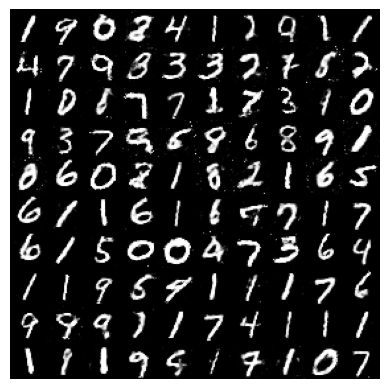

In [ ]:
import os
import torch
import numpy as np
import torchvision.transforms as transforms
import torchvision.utils as vutils
import pickle
import matplotlib.pyplot as plt

# Load models
with open('/content/drive/MyDrive/Advanced ML/G.pkl', 'rb') as f:
    G = pickle.load(f)

with open('/content/drive/MyDrive/Advanced ML/D.pkl', 'rb') as f:
    D = pickle.load(f)

# Create the directory for saving the fake digit images and latent samples
save_dir = "Fake_Digits"
os.makedirs(save_dir, exist_ok=True)

# Generate and save fake digit images
num_images = 100
z_dim = 100  # Adjust this dimension according to your GAN model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available

# Create a blank canvas for the grid
grid = np.zeros((10 * 28, 10 * 28))

for i in range(num_images):
    # Generate a fake digit image
    z = torch.randn(1, z_dim).to(device)  # Move latent vector to the same device as the model
    fake_image = G(z).detach().cpu().numpy().reshape(28, 28)

    # Calculate the row and column indices for the current image
    row = i // 10
    col = i % 10

    # Insert the fake image into the grid
    grid[row * 28: (row + 1) * 28, col * 28: (col + 1) * 28] = fake_image

    # Save the fake digit image
    image_filename = os.path.join(save_dir, f"{i:03d}.png")
    plt.imsave(image_filename, fake_image, cmap='gray')

    # Save the latent sample Z as a text file
    z_filename = os.path.join(save_dir, f"{i:03d}.txt")
    np.savetxt(z_filename, z.detach().cpu().numpy(), fmt='%.6f')

# Save the grid of fake digits as a single image
grid_filename = os.path.join(save_dir, "grid.png")
plt.imshow(grid, cmap='gray')
plt.axis('off')
plt.savefig('Generated_Digits')


##Evaluate the new fake data set
Here the classifier which is created in the CNN class was used.

In [ ]:
import torch

from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

import torch.nn as nn

from torch import optim
from torch.autograd import Variable
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
MNIST_path='/content/gdrive/My Drive/UoM - CSE - Teaching/MSc/CS5621 - Machine Learning/In21 (2021)/Data Sets'

train_data=datasets.MNIST(
    root=MNIST_path,
    train=True,
    transform=ToTensor(),
    download=True,
)


test_data=datasets.MNIST(
    root=MNIST_path,
    train=False,
    transform=ToTensor()
)


100%|██████████| 9912422/9912422 [00:00<00:00, 99255415.07it/s]


Extracting /content/gdrive/My Drive/UoM - CSE - Teaching/MSc/CS5621 - Machine Learning/In21 (2021)/Data Sets/MNIST/raw/train-images-idx3-ubyte.gz to /content/gdrive/My Drive/UoM - CSE - Teaching/MSc/CS5621 - Machine Learning/In21 (2021)/Data Sets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 69658248.32it/s]

Extracting /content/gdrive/My Drive/UoM - CSE - Teaching/MSc/CS5621 - Machine Learning/In21 (2021)/Data Sets/MNIST/raw/train-labels-idx1-ubyte.gz to /content/gdrive/My Drive/UoM - CSE - Teaching/MSc/CS5621 - Machine Learning/In21 (2021)/Data Sets/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26883827.07it/s]


Extracting /content/gdrive/My Drive/UoM - CSE - Teaching/MSc/CS5621 - Machine Learning/In21 (2021)/Data Sets/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/gdrive/My Drive/UoM - CSE - Teaching/MSc/CS5621 - Machine Learning/In21 (2021)/Data Sets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5702043.93it/s]


Extracting /content/gdrive/My Drive/UoM - CSE - Teaching/MSc/CS5621 - Machine Learning/In21 (2021)/Data Sets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/gdrive/My Drive/UoM - CSE - Teaching/MSc/CS5621 - Machine Learning/In21 (2021)/Data Sets/MNIST/raw



In [ ]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),
}

In [ ]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),
}

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=36,  #16
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(36, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization



In [ ]:
cnn=CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 36, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(36, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.01)

In [ ]:
num_epochs = 10

#Remember to run on GPU

def train(num_epochs, cnn, loaders):

    cnn.train()

    # Train the model
    total_step = len(loaders['train'])

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass
        pass
    pass

train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/600], Loss: 0.1707
Epoch [1/10], Step [200/600], Loss: 0.0951
Epoch [1/10], Step [300/600], Loss: 0.0510
Epoch [1/10], Step [400/600], Loss: 0.1334
Epoch [1/10], Step [500/600], Loss: 0.1108
Epoch [1/10], Step [600/600], Loss: 0.0243
Epoch [2/10], Step [100/600], Loss: 0.0304
Epoch [2/10], Step [200/600], Loss: 0.0074
Epoch [2/10], Step [300/600], Loss: 0.0229
Epoch [2/10], Step [400/600], Loss: 0.0637
Epoch [2/10], Step [500/600], Loss: 0.0550
Epoch [2/10], Step [600/600], Loss: 0.1366
Epoch [3/10], Step [100/600], Loss: 0.0938
Epoch [3/10], Step [200/600], Loss: 0.0258
Epoch [3/10], Step [300/600], Loss: 0.1051
Epoch [3/10], Step [400/600], Loss: 0.0211
Epoch [3/10], Step [500/600], Loss: 0.0094
Epoch [3/10], Step [600/600], Loss: 0.0412
Epoch [4/10], Step [100/600], Loss: 0.0490
Epoch [4/10], Step [200/600], Loss: 0.0493
Epoch [4/10], Step [300/600], Loss: 0.0291
Epoch [4/10], Step [400/600], Loss: 0.1062
Epoch [4/10], Step [500/600], Loss: 0.0215
Epoch [4/10

In [ ]:
def test():
  cnn.eval()
  with torch.no_grad():
    correct=0
    total=0
    for images, labels in loaders['test']:
      test_output,last_layer=cnn(images)
      pred_y=torch.max(test_output,1)[1].data.squeeze()
      accuracy=(pred_y==labels).sum().item()/float(labels.size(0))
      pass
    print('Test Acc %.2f' % accuracy)
    pass


test()

Test Acc 1.00


In [ ]:
with open('/content/drive/MyDrive/Advanced ML/C.pkl', 'wb') as f:
    pickle.dump(cnn, f)

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pickle

# Load the trained classifier C from the saved file
with open('/content/drive/MyDrive/Advanced ML/C.pkl', 'rb') as f:
    classifier = pickle.load(f)

# Set up the MNIST test dataset (S0)
transform = transforms.Compose([transforms.ToTensor()])
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
num_samples = 100
indices = torch.randperm(len(mnist_test))[:num_samples]
s0_images = mnist_test.data[indices]
s0_labels = mnist_test.targets[indices]

# Reshape S0 images to match the expected input shape of the classifier
s0_images = s0_images.unsqueeze(1).float()

# Classify the S0 images
s0_outputs, _ = classifier(s0_images)
s0_predicted_labels = torch.argmax(s0_outputs, dim=1)

# Calculate the classification error for S0
s0_error = torch.mean((s0_predicted_labels != s0_labels).float()).item()

print("Classification Error for S0:", s0_error)

# Set up the Fake_Digits dataset (S1)
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
s1_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Advanced ML/Fake_Digits', transform=transform)

# Create the DataLoader for S1
s1_dataloader = torch.utils.data.DataLoader(s1_dataset, batch_size=128, shuffle=False)


# Classify the S1 images
total_samples = 0
total_error = 0

for images, labels in s1_dataloader:
    # Reshape S1 images to match the expected input shape of the classifier
    images = images.unsqueeze(1).float()
    images = images.squeeze(1).float()

    # Forward pass
    s1_outputs, _ = classifier(images)
    s1_predicted_labels = torch.argmax(s1_outputs, dim=1)

    # Calculate the classification error for S1 batch
    batch_error = torch.mean((s1_predicted_labels != labels).float()).item()

    total_samples += labels.size(0)
    total_error += batch_error * labels.size(0)

s1_error = total_error / total_samples

print("Classification Error for S1:", s1_error)


Classification Error for S0: 0.07999999821186066
Classification Error for S1: 0.6847826242446899
